In [1]:
suppressPackageStartupMessages(library(plyr))
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(tidyr))
suppressPackageStartupMessages(library(tibble))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(patchwork))
suppressPackageStartupMessages(library(stringr))
library(hise)
library(parallel)
library(introdataviz)

In [2]:
meta_data<-read.csv('/home//jupyter/BRI_Analysis/scRNA/hise_meta_data_2024-01-23_fixed.csv')
meta_data<-meta_data %>% filter(Covid_exlcusion=='no')

In [3]:
meta<-unique(meta_data[c('subject.subjectGuid','CMV.IgG.Serology.Result.Interpretation','subject.biologicalSex','cohort.cohortGuid')])

In [4]:
colnames(meta)<-c('donor','CMV','Sex','cohorts')

In [5]:
CV_Res_FILES<-list.files(path = "01A_CV_all_timepoint_nonY2D90/", pattern = "csv", all.files = TRUE,
           full.names = TRUE, recursive = FALSE,
           ignore.case = TRUE, include.dirs = TRUE, no.. = FALSE)

In [6]:
CV_Res_meta<-as.data.frame(CV_Res_FILES)

In [7]:
CV_Res_meta<-CV_Res_meta %>%
  mutate(    after_slash = str_extract(CV_Res_FILES, "(?<=//).+"),
    donor = str_extract(CV_Res_FILES, "(?<=//)[^_]+"),
    celltype = str_extract(after_slash, "(?<=_)[^.]+(?=\\.csv)") )%>%
  select(-after_slash)

In [8]:
CV_Res_meta<-left_join(CV_Res_meta,meta)

Joining with `by = join_by(donor)`


In [9]:
meta_data <- meta_data %>%
  group_by(subject.subjectGuid) %>%
  filter(n() >5) %>%
  ungroup()  

In [58]:
gene="TOX"
#gene="SESN3"
#gene="STAT4"
celltype="Core_naive_CD4_T_cell"
#gene="GZMK"
#celltype="GZMK+_CD27+_EM_CD8_T_cell"
mean_expression_list<-mclapply(unique(meta_data$subject.subjectGuid),function(i){  

print(i)
    
meta_data_donor<-meta_data  %>% filter(!sample.visitName %in% c('Flu Year 1 Day 7','Flu Year 2 Day 7','Flu Year 2 Day 90'))%>% filter(subject.subjectGuid == i)    
df_list<-mclapply(seq(from = 1, to = nrow(meta_data_donor), by = 1),function(x){
df<-read.csv(paste0('/home//jupyter/BRI_Analysis/scRNA/Average_Expression_by_Celltype_and_Sample/',pull(meta_data_donor['pbmc_sample_id'])[x],'_AIFI_L3.csv'),row.names = 1,check.names = FALSE)
df<-as.data.frame(df)
colnames(df)<-paste0(pull(meta_data_donor['sample.visitName'])[x],':',colnames(df))   
return(df[gene,])
},mc.cores=nrow(meta_data_donor))

df_all<-do.call(cbind,df_list)
colnames(df_all)<-gsub(" ",'_',colnames(df_all))
df_all<-as.data.frame(t(df_all[, grepl(celltype, names(df_all), fixed = TRUE)]))
df_all$donor<-i
df_all$timepoint_celltype<-rownames(df_all)
rownames(df_all)<-NULL
return(df_all)
    
},mc.cores=30)

In [59]:
mean_df<-do.call(rbind.fill,mean_expression_list)%>% 
  separate(timepoint_celltype, into = c("Flu_Year_Day", "Cell_Type"), sep = ":")
colnames(mean_df)[1]<-"mean_expression"
mean_df=mean_df[!is.na(mean_df$mean_expression),]
mean_df$cohorts<-substr(mean_df$donor,1,3)


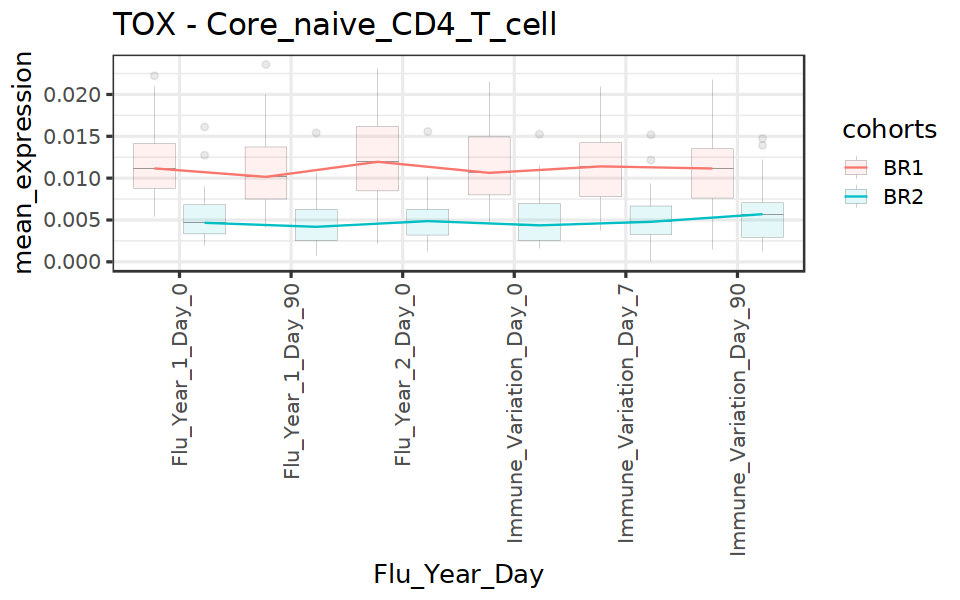

In [60]:
ggplot(mean_df %>% filter(!Flu_Year_Day %in% c('Flu_Year_1_Stand-Alone','Flu_Year_2_Stand-Alone','Flu_Year_3_Stand-Alone')), aes(x = Flu_Year_Day, y = mean_expression, fill = cohorts)) +
  geom_boxplot(position = position_dodge(width = 0.9),size=0.05,alpha=0.1) +
  stat_summary(
    fun.y = median,
    geom = 'line',
    aes(group =cohorts, colour = cohorts),
    position = position_dodge(width = 0.9) #this has to be added
  )+theme_bw(base_size=15)+ 
theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))+ggtitle(paste0(gene,' - ',celltype))

`geom_smooth()` using formula = 'y ~ x'


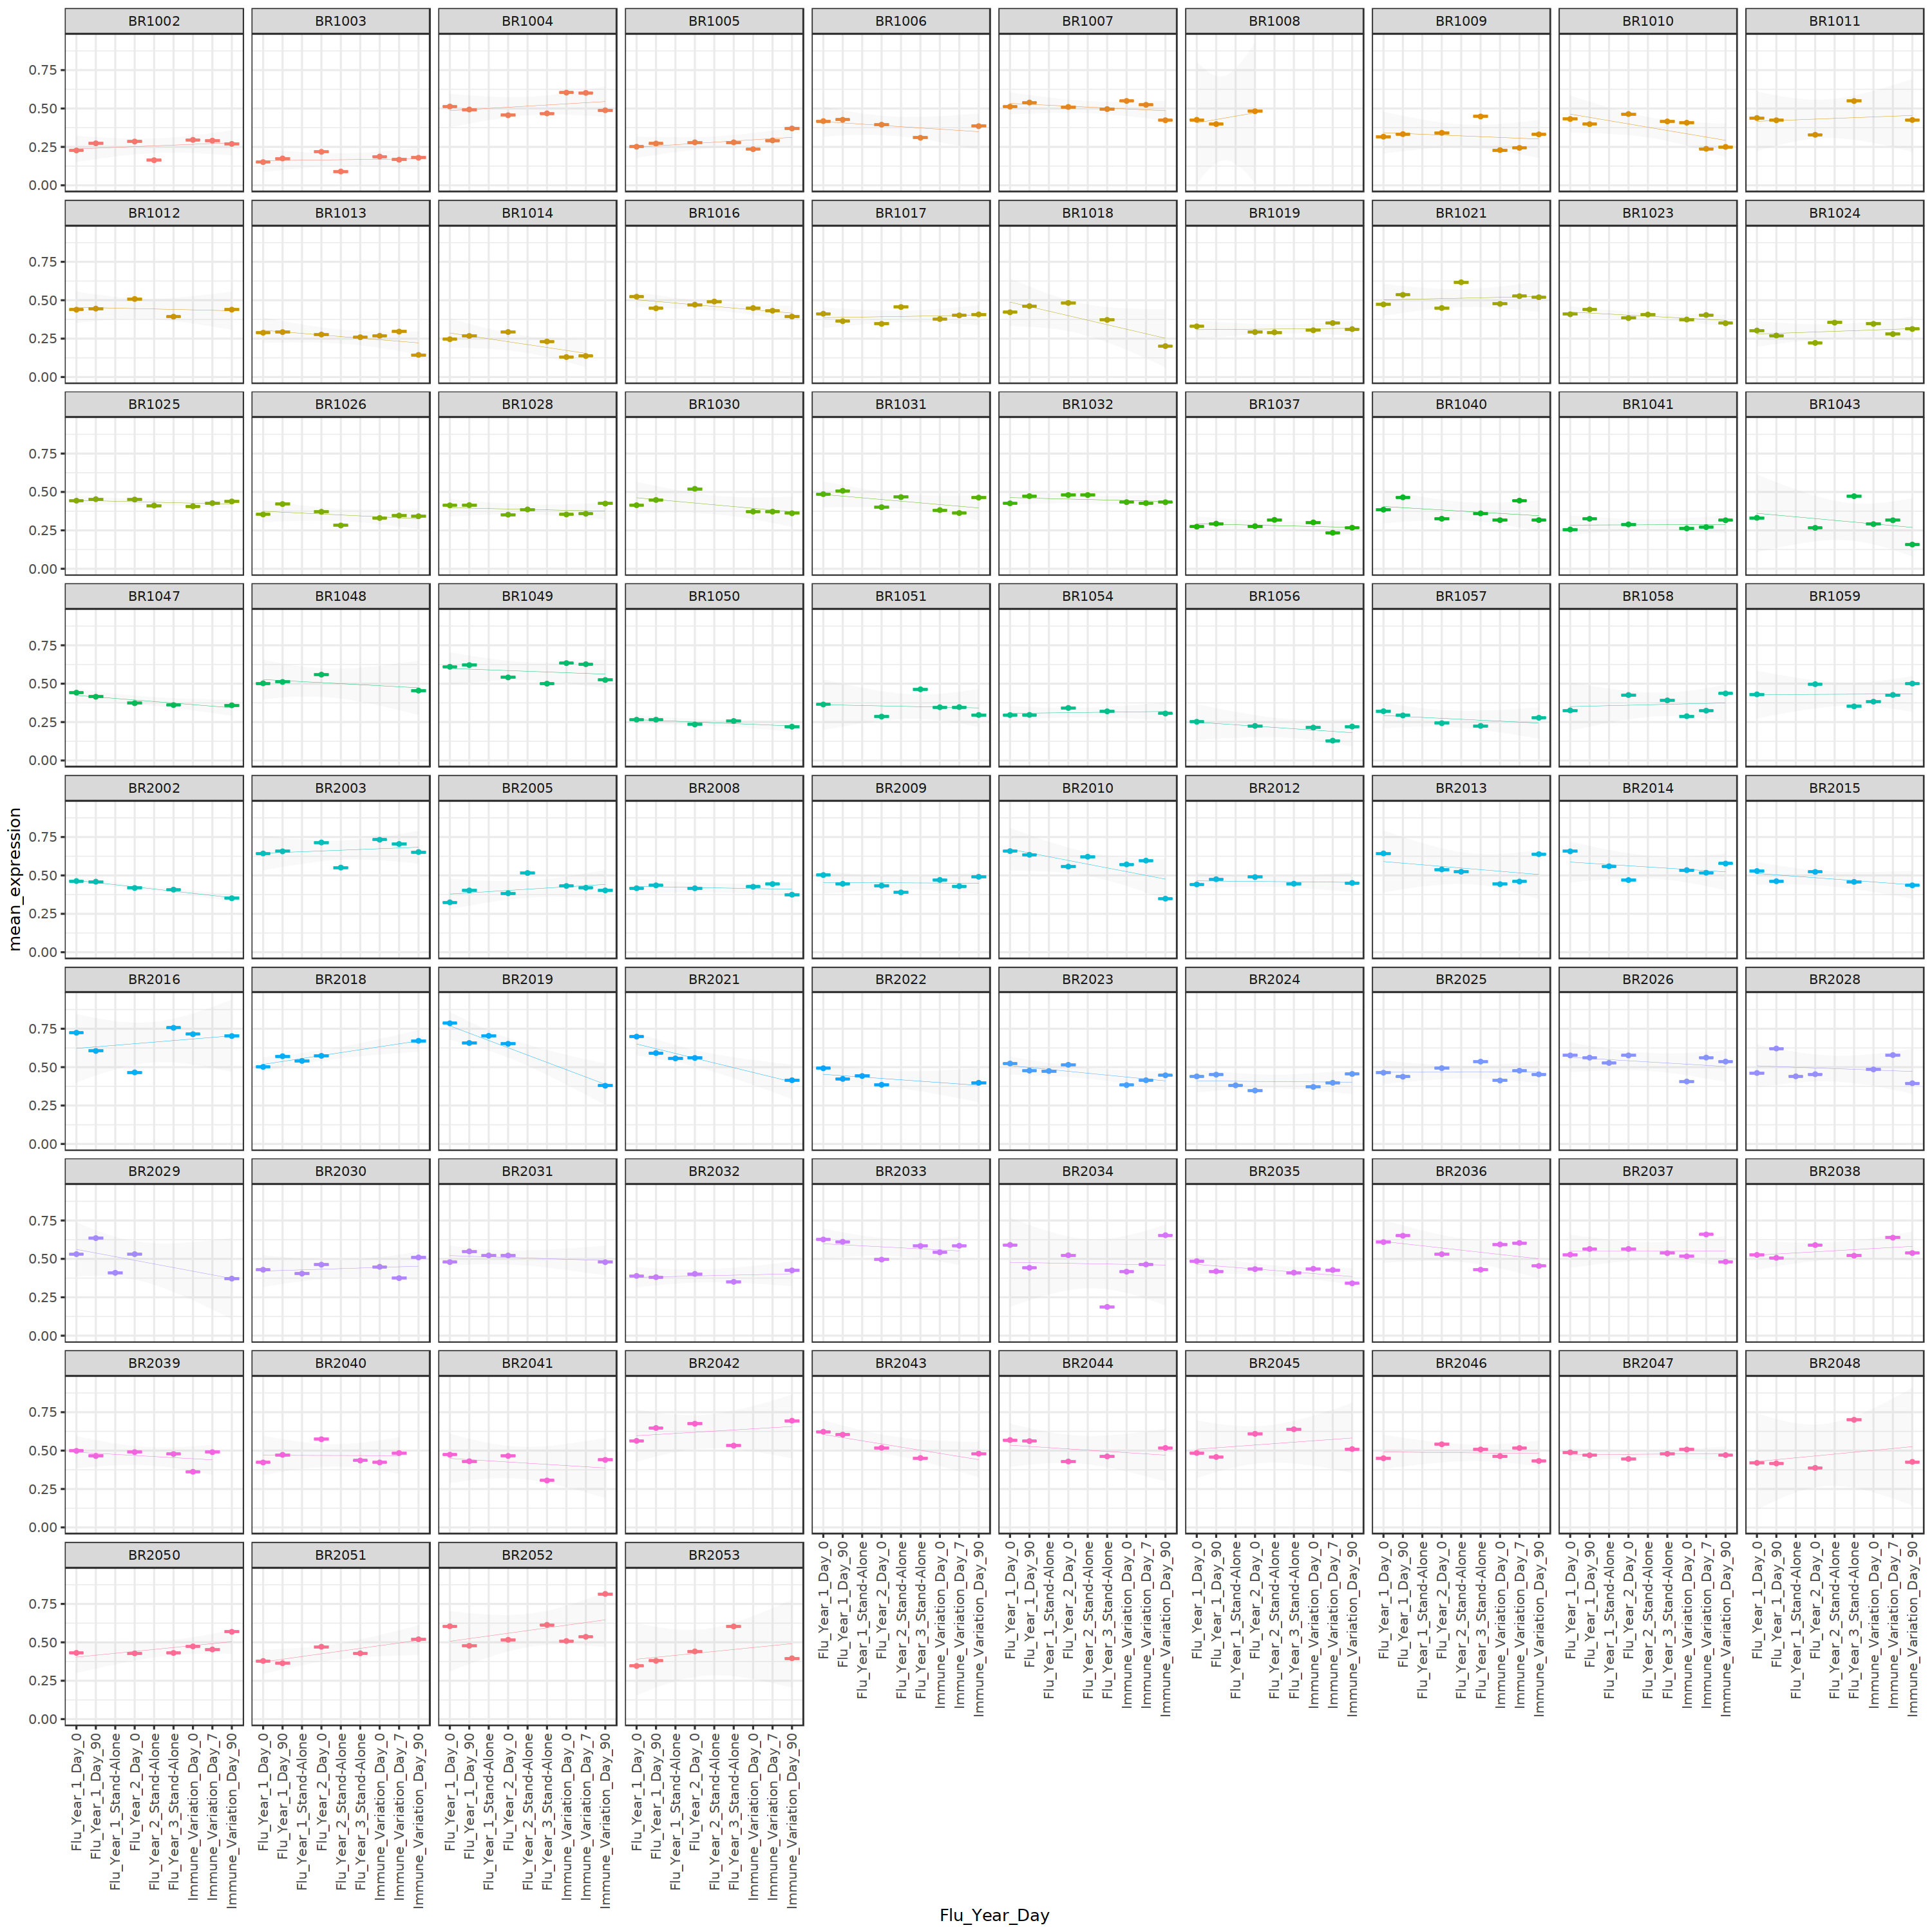

In [12]:
options(repr.plot.width = 25, repr.plot.height = 25)

ggplot(mean_df, aes(x=Flu_Year_Day, y=mean_expression, color=donor))  + 
  geom_boxplot() + geom_point()+
      stat_smooth(aes(group = donor), linewidth=0.1,method = "lm",alpha=0.05, se = TRUE) +facet_wrap(~donor)+theme_bw(base_size=15)+ 
theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))+ theme(legend.position="none")

`geom_smooth()` using formula = 'y ~ x'


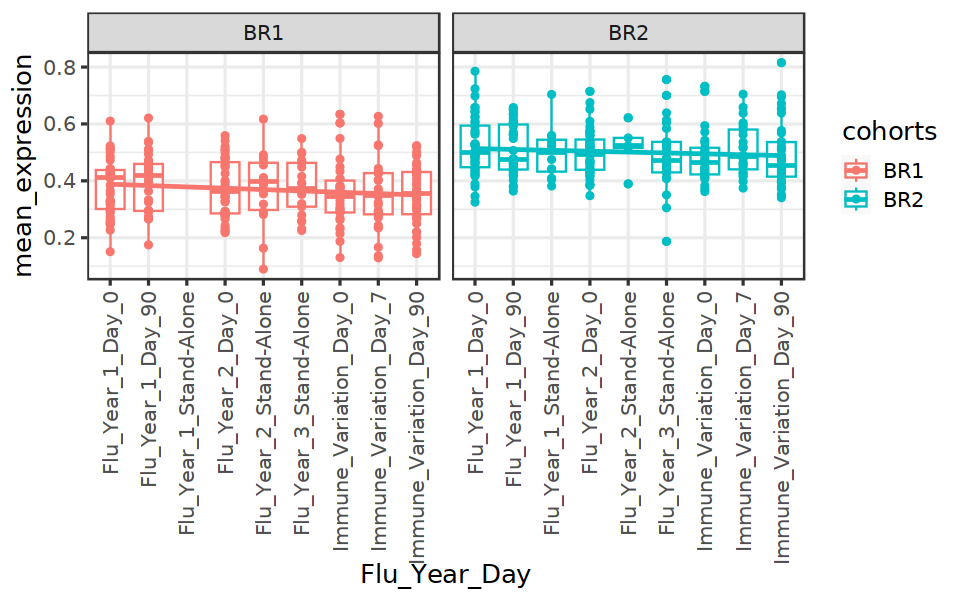

In [13]:
options(repr.plot.width = 8, repr.plot.height = 5)

ggplot(mean_df, aes(x=Flu_Year_Day, y=mean_expression, color=cohorts))  + 
  geom_boxplot() + geom_point()+
      stat_smooth(aes(group = cohorts), method = "lm",alpha=0.05, se = TRUE) +facet_wrap(~cohorts)+theme_bw(base_size=15)+ 
theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))


# All non D7 time point

In [69]:
cell_counts<-read.csv('/home//jupyter/BRI_Analysis/scRNA/cell_counts_BRI.csv',check.names = FALSE)
celltypes<-colnames(cell_counts)[3:73]

In [70]:
meta_data<-read.csv('/home//jupyter/BRI_Analysis/scRNA/hise_meta_data_2024-01-23_fixed.csv')
meta_data<-meta_data %>% filter(Covid_exlcusion=='no')

In [71]:
meta<-unique(meta_data[c('subject.subjectGuid','CMV.IgG.Serology.Result.Interpretation','subject.biologicalSex','cohort.cohortGuid')])

In [72]:
colnames(meta)<-c('donor','CMV','Sex','cohort.cohortGuid')

In [73]:
cell_counts<-left_join(meta_data,cell_counts)

Joining with `by = join_by(pbmc_sample_id)`


In [74]:
CV_Res_FILES<-list.files(path = "01A_CV_all_timepoint_nonY2D90/", pattern = "csv", all.files = TRUE,
           full.names = TRUE, recursive = FALSE,
           ignore.case = TRUE, include.dirs = TRUE, no.. = FALSE)

In [75]:
CV_Res_meta<-as.data.frame(CV_Res_FILES)

In [76]:
CV_Res_meta<-CV_Res_meta %>%
  mutate(    after_slash = str_extract(CV_Res_FILES, "(?<=//).+"),
    donor = str_extract(CV_Res_FILES, "(?<=//)[^_]+"),
    celltype = str_extract(after_slash, "(?<=_)[^.]+(?=\\.csv)") )%>%
  select(-after_slash)

In [77]:
CV_Res_meta<-left_join(CV_Res_meta,meta)

Joining with `by = join_by(donor)`


In [78]:
counts_df_minCell <- data.frame()  

for (i in celltypes) {
cell_counts_subset<-cell_counts[c('pbmc_sample_id',i)]
pbmc_sample_id_filtered<-cell_counts_subset[cell_counts_subset[i]>10,]$pbmc_sample_id      
    meta_data_subset <- meta_data %>% filter(pbmc_sample_id %in% pbmc_sample_id_filtered)

    # Check if meta_data_subset is empty
    if (nrow(meta_data_subset) == 0) {
        next  # Skip to the next iteration if no data
    }

    sample_counts <- as.data.frame(table(meta_data_subset$subject.subjectGuid))
    sample_counts$celltypes <- i
    
    colnames(sample_counts) <- c('donor', 'number_of_timepoint_with_minCell', 'celltypes')
    counts_df_minCell <- rbind.fill(counts_df_minCell, sample_counts)
}
counts_df_minCell$celltypes<-gsub(' ','_',counts_df_minCell$celltypes)

In [79]:

df_list<-mclapply(pull(CV_Res_meta['CV_Res_FILES']),function(x){
df<-read.csv(x) %>% filter(mean>=0.1)
return(df)
},mc.cores=60)


In [80]:
df_all<-do.call(rbind, df_list)
df_all<-left_join(df_all,meta)

Joining with `by = join_by(donor)`


In [81]:
df_all<-left_join(df_all,counts_df_minCell)

Joining with `by = join_by(celltypes, donor)`


In [82]:
# filter out samples does not contian 4 time point and genes has zero expression in any of 4 time point

df_all<-df_all %>% filter(number_of_timepoint>5,number_of_timepoint_non_zero_expr>5,number_of_timepoint_with_minCell>5)#%>%


In [83]:
df=as.data.frame(table(df_all$X,df_all$celltypes,df_all$cohort.cohortGuid))
colnames(df)<-c('X',"celltypes",'cohort.cohortGuid','donor_counts')

In [84]:
df_all_averge<-df_all %>% group_by(celltypes,X,cohort.cohortGuid) %>%   
                    dplyr::summarise(cv_average = mean(cv),
                                     mean_average = mean(mean),
                                    variance_average = mean(variance),
                                    sd_average = mean(sd),) 

`summarise()` has grouped output by 'celltypes', 'X'. You can override using
the `.groups` argument.


In [85]:
# filter gene by at least 10 donor in each cohorts

df_all_averge<-left_join(df_all_averge,df)
df_all_averge<-df_all_averge %>%
  group_by(celltypes,X) %>%
  filter(all(donor_counts > 10)) %>%
  ungroup()

Joining with `by = join_by(celltypes, X, cohort.cohortGuid)`


In [86]:
selected_celltype<-as.data.frame(table(df_all_averge$celltypes,df_all_averge$cohort.cohortGuid)) %>%
  group_by(Var1) %>%
  filter(all(Freq > 1000)) %>%
  ungroup()

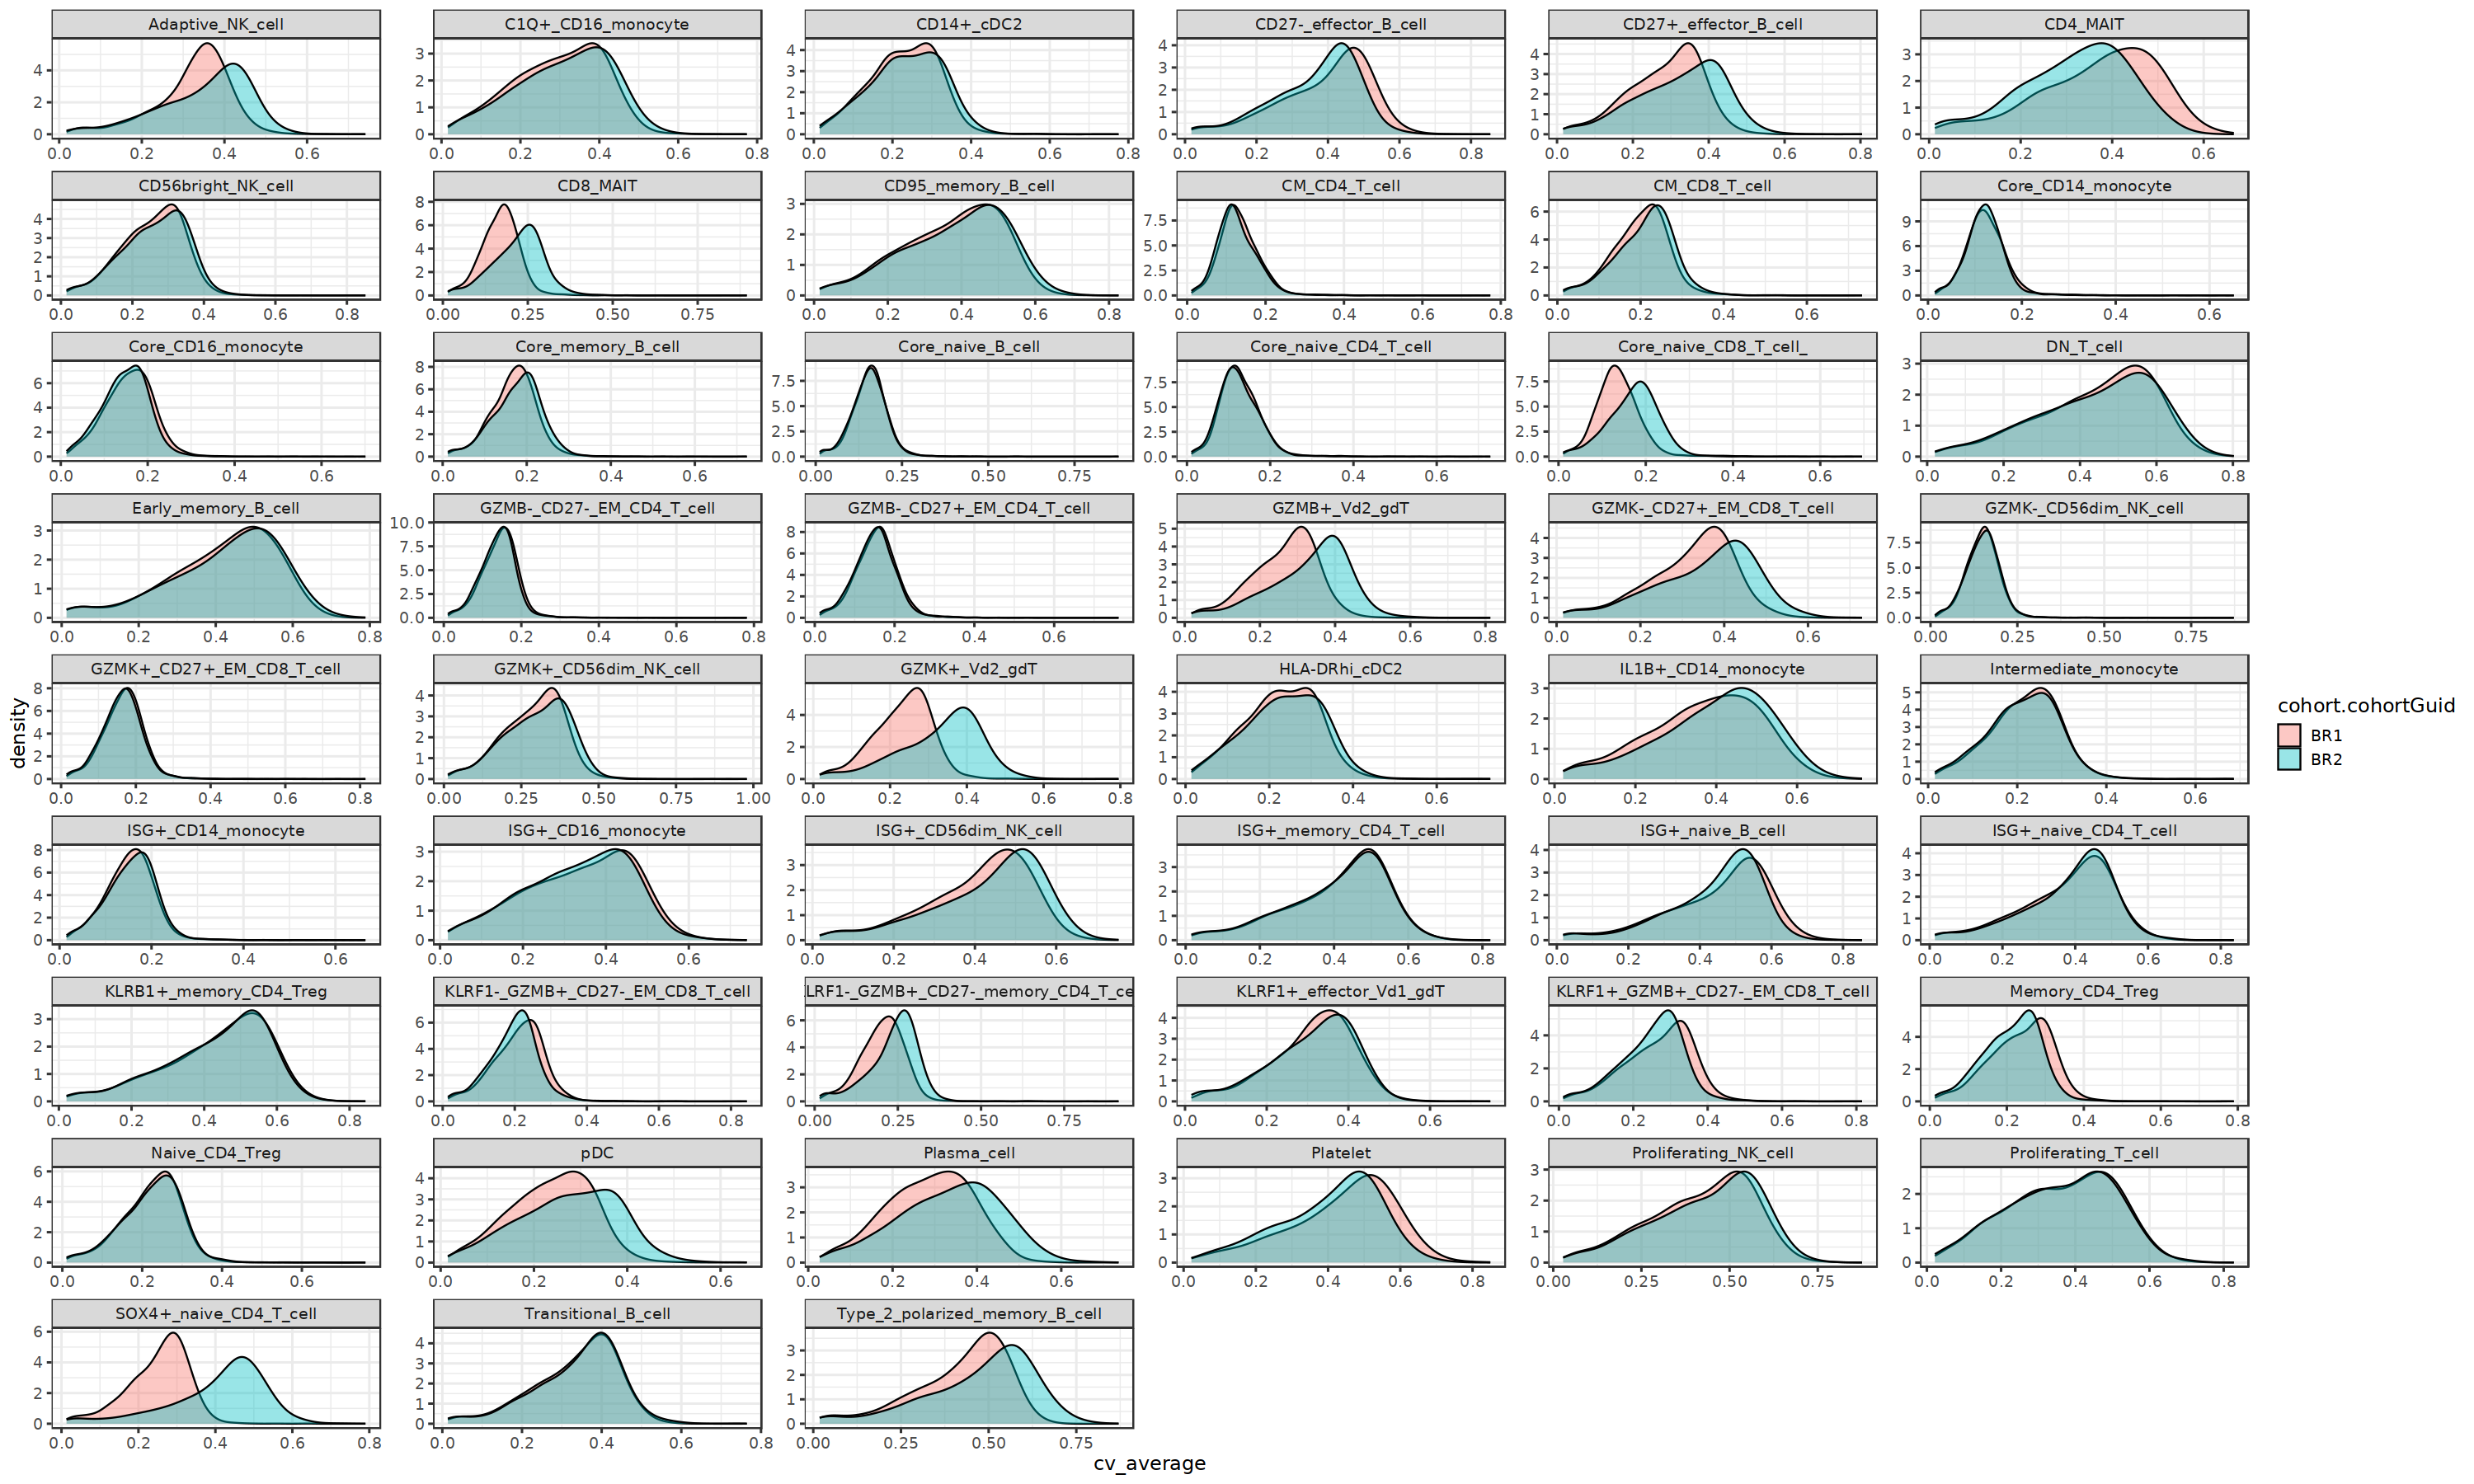

In [87]:
options(repr.plot.width = 25, repr.plot.height = 15)
P<-ggplot(data=df_all_averge%>% filter (celltypes %in% selected_celltype$Var1), aes(x=cv_average,group=cohort.cohortGuid, fill=cohort.cohortGuid)) +
    geom_density(adjust=1.5, alpha=.4) +
    theme_bw(base_size=14)+facet_wrap(~celltypes,ncol=6,scale='free')
P

In [88]:
c('Adaptive_NK_cell','CD8_MAIT','Core_naive_CD8_T_cell_','GZMB+_Vd2_gdT','GZMK+_Vd2_gdT', 'SOX4+_naive_CD4_T_cell')

[1] "Adaptive_NK_cell"       "CD8_MAIT"               "Core_naive_CD8_T_cell_"
[4] "GZMB+_Vd2_gdT"          "GZMK+_Vd2_gdT"          "SOX4+_naive_CD4_T_cell"

In [89]:
df_all_averge_sub<-df_all_averge %>% filter (celltypes %in% c('Adaptive_NK_cell','CD8_MAIT','Core_naive_CD8_T_cell_','GZMB+_Vd2_gdT','GZMK+_Vd2_gdT', 'SOX4+_naive_CD4_T_cell'))

In [90]:
df_all_averge_sub_top20<-df_all_averge_sub %>% group_by(cohort.cohortGuid,celltypes) %>% 
top_n(20,cv_average) %>% 
arrange(cv_average) %>% 
filter(cohort.cohortGuid=='BR1')

In [91]:
cv_log2fc<- df_all_averge %>%
  group_by(celltypes, X) %>%
  filter(n() == 2) %>%
  arrange(celltypes, X, cohort.cohortGuid)%>%
  summarise(
    log2fc = log2(last(cv_average) / first(cv_average)),
    delta_changes = last(cv_average) - first(cv_average),
    cv_BR1=first(cv_average),
    cv_BR2=last(cv_average),    
    mean_BR1=first(mean_average),
    mean_BR2=last(mean_average),
    .groups = 'drop' 
  )


In [92]:
cv_log2fc_sub<-cv_log2fc %>% filter (celltypes %in% c('Adaptive_NK_cell','CD8_MAIT',
                                       'Core_naive_CD8_T_cell_','GZMB+_Vd2_gdT',
                                       'GZMK+_Vd2_gdT', 
                                       'SOX4+_naive_CD4_T_cell'))%>% 
group_by(celltypes) %>% 
top_n(20,abs(log2fc)) %>% 
arrange(log2fc) 


In [93]:
write.csv(cv_log2fc_sub,'cv_delta_top20.csv')

# Mean plots

In [94]:
cv_log2fc_sub<-cv_log2fc %>% filter (celltypes %in% c('Adaptive_NK_cell','CD8_MAIT',
                                       'Core_naive_CD8_T_cell_','GZMB+_Vd2_gdT',
                                       'GZMK+_Vd2_gdT', 
                                       'SOX4+_naive_CD4_T_cell'))%>% 
group_by(celltypes) %>% 
top_n(5,abs(log2fc)) %>% 
arrange(log2fc) 

In [209]:
cv_log2fc_sub<-cv_log2fc_sub %>% 
  mutate(celltypes = case_when(
    celltypes == 'Core_naive_CD8_T_cell_' ~ 'Core_naive_CD8_T_cell',
    TRUE ~ celltypes
  ))

In [188]:
tt_1<-cv_log2fc_sub%>% filter(celltypes=='Adaptive_NK_cell') %>% ungroup %>% select(X,cv_BR1,mean_BR1)
tt_1$cohorts='BR1'
colnames(tt_1)<-c('Gene','mean_cv','mean_exp','cohorts')
tt_2<-cv_log2fc_sub%>% filter(celltypes=='Adaptive_NK_cell') %>% ungroup %>% select(X,cv_BR2,mean_BR2)
tt_2$cohorts='BR2'
colnames(tt_2)<-c('Gene','mean_cv','mean_exp','cohorts')
tt<-rbind(tt_1,tt_2) 

In [96]:
celltypes<-c('Adaptive_NK_cell','CD8_MAIT',
                                       'Core_naive_CD8_T_cell','GZMB+_Vd2_gdT',
                                       'GZMK+_Vd2_gdT', 
                                       'SOX4+_naive_CD4_T_cell')

In [221]:
celltypes<-c('Core_naive_CD8_T_cell')

In [222]:
for (celltype in celltypes){

gene<-cv_log2fc_sub %>% filter(celltypes==celltype) %>% select(X)%>% pull()
mean_expression_list<-mclapply(unique(meta_data$subject.subjectGuid),function(i){  


print(i)    
meta_data_donor<-meta_data  %>% filter(!sample.visitName %in% c('Flu Year 1 Day 7','Flu Year 2 Day 7','Flu Year 2 Day 90'))%>% filter(subject.subjectGuid == i)    
df_list<-mclapply(seq(from = 1, to = nrow(meta_data_donor), by = 1),function(x){
df<-read.csv(paste0('/home//jupyter/BRI_Analysis/scRNA/Average_Expression_by_Celltype_and_Sample/',pull(meta_data_donor['pbmc_sample_id'])[x],'_AIFI_L3.csv'),row.names = 1,check.names = FALSE)
df<-as.data.frame(df)
colnames(df)<-paste0(pull(meta_data_donor['sample.visitName'])[x],':',colnames(df))   
df_sub <- rownames_to_column(df[gene,], var = "Gene")
long_data <- pivot_longer(df_sub, cols = -Gene, names_to = "Measurement", values_to = "Value")

long_data$donor<-meta_data_donor$subject.subjectGuid[1]
long_data<-long_data%>% 
separate(Measurement, into = c("Flu_Year_Day", "Cell_Type"), sep = ":")
    
return(long_data)
},mc.cores=nrow(meta_data_donor))

df_all<-do.call(rbind,df_list)
#df_all<-df_all %>% filter(Cell_Type==celltype)
return(df_all)
    
},mc.cores=30)  
mean_df<-do.call(rbind,mean_expression_list)
mean_df$cohorts<-substr(mean_df$donor,1,3)

    }

Adding missing grouping variables: `celltypes`


In [232]:
mean_df<-mean_df %>% filter(Cell_Type=='Core naive CD8 T cell ')
tt_1<-cv_log2fc_sub %>% 
  mutate(celltypes = case_when(
    celltypes == 'Core_naive_CD8_T_cell' ~ 'Core_naive_CD8_T_cell_',
    TRUE ~ celltypes
  ))%>% filter(celltypes=='Core_naive_CD8_T_cell_') %>% ungroup %>% select(X,cv_BR1,mean_BR1)
tt_1$cohorts='BR1'
colnames(tt_1)<-c('Gene','mean_cv','mean_exp','cohorts')
tt_2<-cv_log2fc_sub%>% 
  mutate(celltypes = case_when(
    celltypes == 'Core_naive_CD8_T_cell' ~ 'Core_naive_CD8_T_cell_',
    TRUE ~ celltypes
  ))%>% filter(celltypes=='Core_naive_CD8_T_cell_') %>% ungroup %>% select(X,cv_BR2,mean_BR2)
tt_2$cohorts='BR2'
colnames(tt_2)<-c('Gene','mean_cv','mean_exp','cohorts')
tt<-rbind(tt_1,tt_2) 
p<-ggplot(mean_df, aes(x=Flu_Year_Day, y=Value, color=donor)) + 
  geom_boxplot() + geom_point() +
  stat_smooth(aes(group = donor), linewidth=0.1, method = "lm", alpha=0.05, se = TRUE) +
  facet_wrap(~Gene + cohorts, ncol=2) +
  theme_bw(base_size=15)+
  theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1),
        legend.position="none") + geom_text(data=tt, aes(x=6, y=mean_exp+1, label=paste0("Average CV: ",as.character(round(mean_cv, 5)))), inherit.aes = FALSE) 
ggsave(paste0(celltype,'.pdf'),p,width=10,height=15)


`geom_smooth()` using formula = 'y ~ x'
Warning message in qt((1 - level)/2, df):
“NaNs produced”
Warning message in qt((1 - level)/2, df):
“NaNs produced”
Warning message in qt((1 - level)/2, df):
“NaNs produced”
Warning message in qt((1 - level)/2, df):
“NaNs produced”
Warning message in qt((1 - level)/2, df):
“NaNs produced”
Warning message in qt((1 - level)/2, df):
“NaNs produced”
Warning message in qt((1 - level)/2, df):
“NaNs produced”
Warning message in qt((1 - level)/2, df):
“NaNs produced”
Warning message in qt((1 - level)/2, df):
“NaNs produced”
Warning message in qt((1 - level)/2, df):
“NaNs produced”
Warning message in qt((1 - level)/2, df):
“NaNs produced”
Warning message in qt((1 - level)/2, df):
“NaNs produced”
Warning message in qt((1 - level)/2, df):
“NaNs produced”
Warning message in qt((1 - level)/2, df):
“NaNs produced”
Warning message in qt((1 - level)/2, df):
“NaNs produced”
Warning message in qt((1 - level)/2, df):
“NaNs produced”
Warning message in qt((1 - level